# Plotting Trajectories
Author: Talia Borofsky  
Date:   Started 2/25/21  
Project: Static environments with limited resources select for multiple foraging strategies rather than conformity  
Description:
- This code plots trajectories for interesting paramater combinations. We first plot $u_1, u_2, r_1, r_2$ trajectories for a population entirely made up of the resident phenogenotype $AB$. Then we show trajectories of $p_1, p_2, r_1, r_2, x, u$ when allele $a$ invades and $p_1, p_2, r_1, r_2, y,u$ when $b$ invades.
- Data structures used are numpy arrays, tuples, lists, and dataframes loaded from csv files in the folder. 
- In particular, note that we use the program ternary to plot ternary plots

In [172]:
import numpy as np
#import importlib
from numpy import linalg
import helperfuns
from helperfuns import *
import DatFrameFuns
from DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
#import sympy as sp
#from sympy import *
#from sympy.solvers import solve
#np.set_printoptions(precision=3, suppress = True)
#import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator

# for ternary plots
import ternary


# for formatting tick labels
#from matplotlib.ticker import FormatStrFormatter

#for parallelizing:
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

## Internal Stability

### Functions

In [386]:
# functio make_internal_traj_plots
# Summary: 
#       Plots the trajectories of u1, u2, bu, r1, and r2 when u = 1, 
#       i.e. all individuals are resident type AB
# Parameters
#       init_pts: a dataframe that is a subset of the dataframe from data.csv that shows initial points,
#                 mode parameters, and final equilibrium. Parameters are the same for each initial point
#       colors: The colors corresponding to each row of the init_pts dataframe.
# Returns:
#       returns the axes and figure handles for the ternary plot and the cartesian plot
#       Also returns a dataframe of the trajectories
# Description:
#       u1,u2,bu are plotted in a ternary plot. 
#       r1 and r2 are plotted on a cartesian plot

def make_internal_traj_plots(init_pts, colors):
    # format axes and figures
    fig_u, tax = format_my_ternary() # initiates a ternary plot and formats axes
    fig_r, ax_r = format_r_plot() # initiates cartesian plot and formats axes
    init_pts['color'] = colors # put in column for color
    
    # for each initial point, we find the trajectory and plot it
    # we want to record these trajectories. I'll make a dataframe of points for each trajectory, 
    # and then stack these dataframes into one master frame
    
    nrow = len(init_pts)
    row_list = np.array_split(init_pts,nrow)
    
    traj_df_list = [get_trajectory(row) for row in row_list]
    
    
    plot_my_traj_u(traj_df_list,init_pts,fig_u,tax)
    plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r)
    
    
    trajectories_df = pd.concat(traj_df_list) # makes a dataframe of all the trajectories
    # colnames = ["u1","u2","bu","r1","r2","timestep","color"]
    # trajectories_df = pd.DataFrame(trajectories_mat,columns = colnames)
    
    trajectories_df = pd.merge(left=trajectories_df, right=init_pts, 
                               on = 'color').sort_values(by=['color','tstep'])

    return(tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list)

# function format_my_ternary
# Summary: Sets up a ternary plot
# Parameters: None
# Returns: Handles to the figure and ternary axis
# Description:
#   Uses package ternary to create a ternary plot
#   Gets rid of the outer box and sets tick marks and axis labels
def format_my_ternary():
    scale = 1
    fig_u, tax = ternary.figure(scale=scale)
    
    # set up bounderize and size
    fig_u.set_size_inches(8,8)
    tax.boundary()
    
    # tick preferences
    tax.ticks(axis='lbr', multiple=.2, linewidth=1, 
              offset = 0.02, tick_formats = "%.1f"), 
    
    # turn off matplotlib's outer box and ticks
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Label corners - removed this for now
    fontsize = 20
    #tax.right_corner_label(r'$u_1$', fontsize=fontsize, offset = 0.2)
    #tax.top_corner_label(r'$u_2$', fontsize=fontsize, offset = 0.2)
    #tax.left_corner_label(r'$\bar{u}$', fontsize=fontsize, offset = 0.2)

    # Label sides
    tax.left_axis_label(r'$\bar{u}$', fontsize = fontsize, offset=0.14)
    tax.right_axis_label(r'$u_2$', fontsize = fontsize, offset=0.14)
    tax.bottom_axis_label(r'$u_1$', fontsize = fontsize, offset=0.14)
    return(fig_u,tax)

def format_r_plot():
    
    fig, ax = plt.subplots(1,1,figsize = (6,6))
    ax.set_xlabel(r'$r_1$', fontsize = 20)
    ax.set_ylabel(r'$r_2$', fontsize = 20)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    #ax.legend(loc = 'best', fontsize = 14)
        #TO-DO// FILL IN


    return(fig,ax)

def get_trajectory(row):
    
    # assigning columns to variables for more readability
    K,pc,D,beta, u1, u2, bu, r1, r2 = np.transpose(row[['K','pc','D','beta', 'u1init','u2init',
                                                       'buinit', 'r1init','r2init']].values)
    uvec = [u1,u2,bu]; rvec = [r1,r2]
    xvec = [0,0,0]
    yvec = [0,0,0]
    list_rows = []
    eq_pt = row[['u1eq','u2eq','bueq','r1eq','r2eq']]
    for t in range(0,200):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2], "r1":rvec[0], "r2": rvec[1],
                                 "tstep":t, "color":row.color})
        list_rows.append(curr_row)
        curr_pt = curr_row[['u1','u2','bu','r1','r2']]
        if np.allclose(curr_pt, eq_pt,rtol = 1e-6, atol = 1e-6):
            break
        else:
            uvec,xvec,yvec,rvec,W = NextGen(uvec,xvec,yvec,rvec,D,K,pc,beta)
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))
        
    
def plot_my_traj_u(traj_df_list, init_pts, fig_u, tax):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep")
        umat = traj_df[['u1','u2','bu']].values
        trajectory = list(map(tuple,umat))
    #color = traj_df.color[0]
        tax.plot(trajectory, color = traj_df.color.values[0], label = "Starting with IP %d"%i)
    
    # plot initial points as black squares
    init_u_pts = list(map(tuple, init_pts[['u1init','u2init','buinit']].values ))
    tax.scatter(init_u_pts, marker='s', color='k', label="Initial Points")
    equilibria = pd.unique(list(map(tuple, init_pts[['u1eq','u2eq','bueq']].values )))
    
    # plot equilibrium (or equilibria) as a black star
    eqlabel = 'equilibrium' if len(equilibria) == 1 else 'equilibria'
    tax.scatter(equilibria, marker = '*', color = 'k', label = eqlabel, s = 200)
    tax.legend(loc="best", fontsize=14)
    tax.resize_drawing_canvas(scale=1.05)
    

    return(1)

# function get_trajectory(row)
# Summary: Iterates from initial point until it approximately reaches equilibrium
# parameters:
#    row - a row from the init_pts dataframe.
# Returns:
#    traj_df, a dataframe with the values of u1, u2, bu, r1, r2 for each time step until they reach the equilibrium
# Description:
#    iterate until u1 \approx u1eq, u2 \approx u2eq, etc. u1eq, u2eq, ... are from row
#    formats each iteration as a row in a dataframe, then appends to a list
#    the list is fed into pd.concat to make a full dataframe

# Function plot_my_traj_r
# Summary: Plots the trajectory of (r1, r2)
# Parameters: 
#    traj_df_list = The list of trajectory dataframes
#    init_pts = data frame with the inital points and equilibrium information
#    fig_r, ax_r = handles to the figure and axis set up in format_r_plot
# Returns: None (put return(1))
# Description:
#    Loops through trajectory_df's and plots them
#    Plots equilibrium(a) point(s) and initial points
def plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep") # sorting just in case
        r1vec = traj_df.r1
        r2vec = traj_df.r2
        ax_r.plot(r1vec, r2vec, color = traj_df.color.values[0], label = "Starting with IP %d"%i)
    
    # plot initial points as black squares
    r1init = init_pts.r1init.values
    r2init = init_pts.r2init.values
    ax_r.scatter(r1init, r2init, marker='s', color='k', label="Initial Points")
    
    # plot equilibrium(a)
    equilibria = pd.unique(list(map(tuple, init_pts[['r1eq','r2eq']].values ))) # pd.unique needs a list of tuples
    r1eq_vec = [point[0] for point in equilibria]
    r2eq_vec = [point[1] for point in equilibria]
    eqlabel = 'equilibrium' if len(equilibria) == 1 else 'equilibria'
    ax_r.scatter(r1eq_vec, r2eq_vec, marker = '*', color = 'k', label = eqlabel, s = 200)
    #ax_r.legend(loc = "best", fontsize=14)
    return(1)


### Load DataFrames

In [389]:
print("Version", ternary.__version__)

Version 1.0.6


In [387]:
df_UniqueEquilibria = pd.read_csv('UniqueEquilibriaDF.csv')
df_InitialPoints = pd.read_csv('data.csv')



### Choose paramater combo to look at and initial points
Store the equilibria. We will use this for stopping the trajectory function

I'll choose a value where there is moderate food depletion ($\beta = 0.5$) and poor information ($\mu = -0.5$)

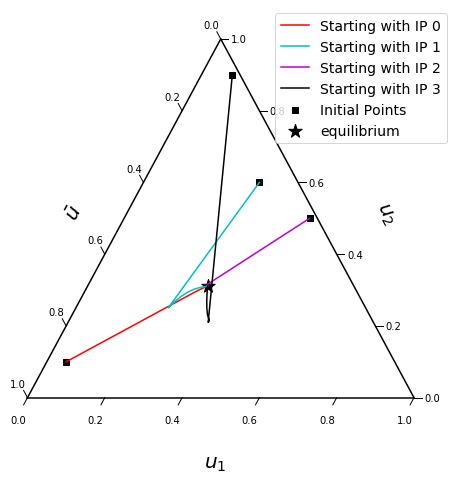

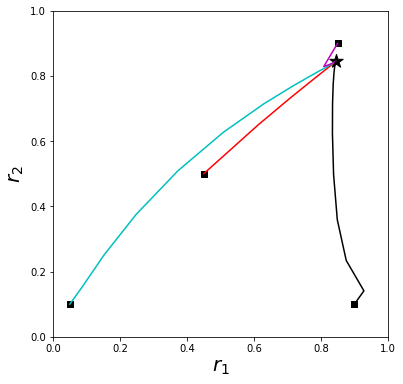

In [388]:
# choose equilibria where 
row_init_eq = df_UniqueEquilibria.query('K==0 & x_pos_invades==True & beta == 0.5 & D==0 & mu==-0.5')
init_pts_all = df_InitialPoints.query('K==0 & beta == 0.5 & D==0 & mu == -0.5')

colors = ['r','c','m','k']
# choose initial points
row1 = init_pts_all.query('u1init==0.05 &  u2init == 0.1 & r1init == 0.45 & r2init ==0.5')
row2 = init_pts_all.query('u1init==0.3 &  u2init == 0.6 & r1init == 0.05 &  r2init ==0.1 ')
row3 = init_pts_all.query('u1init==0.48 &  u2init == 0.5 & r1init == 0.85 & r2init ==0.9')
row4 = init_pts_all.query('u1init==0.08 &  u2init == 0.9 & r1init == 0.9 &  r2init ==0.1 ')
init_pts = pd.concat([row1,row2,row3,row4])

# plot trajectories for each initial point
tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list = make_internal_traj_plots(init_pts, colors)

fig_u.savefig("TrajectoryPlots/u_intern_K_0_D_0_beta_0_5_mu_neg0_5")
fig_r.savefig("TrajectoryPlots/r_intern_K_0_D_0_beta_0_5_mu_neg0_5")